In [1]:
# 决策树
dt =  {'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}

In [2]:
# 构造迭代器，并进行一次迭代
dt_iter = next(iter(dt))
dt_iter

'有自己的房子'

In [3]:
# 获取下一个字典
dt[dt_iter]

{0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}

In [4]:
type(dt)

dict

In [5]:
type(dt).__name__

'dict'

In [6]:
import operator
# ref: https://www.cnblogs.com/mululu/p/10538695.html
# operator模块提供的itemgetter函数用于获取对象的哪些维的数据，参数为一些序号（即需要获取的数据在对象中的序号）
# 要注意，operator.itemgetter函数获取的不是值，而是定义了一个函数，通过该函数作用到对象上才能获取值。
k = [3,6,8]
b = operator.itemgetter(1)
print(b(k))

6


In [7]:
students = [('john', 'C', 15), ('jane', 'A', 12), ('dave', 'B', 10)]
s = sorted(students,key = operator.itemgetter(1,2))
print(s)

[('jane', 'A', 12), ('dave', 'B', 10), ('john', 'C', 15)]


In [8]:
# Q：找到年龄最大的人，并输出，
person = {"li":18,"wang":50,"zhang":20,"sun":22}
def fun(person):
    max = 0
    name = ""
    
    for key, value in person.items():
        if value > max:
            max = value
            name = key
    print(name)
    print(max)
    
fun(person)

wang
50


In [9]:
import operator
person = {"li":18,"wang":50,"zhang":20,"sun":22}

print(max(person.values() )  )
print(max(person.items(), 
          key = operator.itemgetter(1))[0]
     )  # 获取最大值的 key

50
wang


第0个特征的信息增益为0.083
第1个特征的信息增益为0.324
第2个特征的信息增益为0.420
第3个特征的信息增益为0.363
--------------------------------
最优特征索引值:2
第0个特征的信息增益为0.083
第1个特征的信息增益为0.324
第2个特征的信息增益为0.420
第3个特征的信息增益为0.363
--------------------------------
第0个特征的信息增益为0.252
第1个特征的信息增益为0.918
第2个特征的信息增益为0.474
--------------------------------
构建好的决策树为: {'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}
--------------------------------


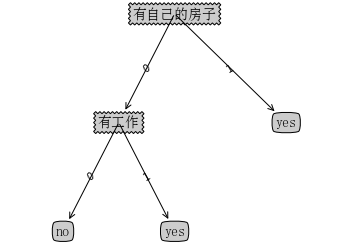

放贷
--------------------------------
{'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}


In [10]:
import operator
import pickle
from math import log
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties


def create_dataset(dataset=None, labels=None):
    """
    构造贷款数据集
    :return: 返回数据集和是否放贷(二类)
    """
    if not dataset:
        dataset = [[0, 0, 0, 0, 'no'],
                   [0, 0, 0, 1, 'no'],
                   [0, 1, 0, 1, 'yes'],
                   [0, 1, 1, 0, 'yes'],
                   [0, 0, 0, 0, 'no'],
                   [1, 0, 0, 0, 'no'],
                   [1, 0, 0, 1, 'no'],
                   [1, 1, 1, 1, 'yes'],
                   [1, 0, 1, 2, 'yes'],
                   [1, 0, 1, 2, 'yes'],
                   [2, 0, 1, 2, 'yes'],
                   [2, 0, 1, 1, 'yes'],
                   [2, 1, 0, 1, 'yes'],
                   [2, 1, 0, 2, 'yes'],
                   [2, 0, 0, 0, 'no']]

    if not labels:
        labels = ['不放贷', '放贷']
        # labels = ['年龄', '有工作', '有自己的房子', '信贷情况']

    return dataset, labels


def calculate_shannon_entropy(dataset):
    """
    计算给定数据集的香农熵（经验熵）
    :param dataset: 数据集
    :return: 香农熵
    """
    # 数据集的行数
    data_rows = len(dataset)
    # 字典对象保存每个标签出现次数
    label_counts = {}
    # 初始化香农熵
    shannon_entropy = 0.0

    for feature_vector in dataset:
        # 提取标签信息
        current_label = feature_vector[-1]
        # 将标签存入字典
        if current_label not in label_counts.keys():
            label_counts[current_label] = 0
        label_counts[current_label] += 1

    # 计算香农熵
    for key in label_counts:
        # 选择该标签的概率
        label_prob = float(label_counts[key]) / data_rows
        # 香农熵计算公式
        shannon_entropy -= label_prob * log(label_prob, 2)

    return shannon_entropy


def split_dataset(dataset, axis, value):
    """
    按照特定特征划分数据集
    :param dataset: 待划分的数据集, 2d array
    :param axis: 划分数据集的特征
    :param value: 需要返回的特征的值
    :return: 返回划分后的数据
    """
    rest_dataset = []
    # 遍历数据集
    for feature_vector in dataset:
        if feature_vector[axis] == value:
            # 去掉axis特征
            # 首先保存axis特征之前的元素
            reduced_feature_vector = feature_vector[:axis]
            # 将axis特征之后的元素数据添加到临时变量中
            reduced_feature_vector.extend(feature_vector[axis + 1:])
            # 经过以上两步操作，已经将axis位置的元素去掉，并保存为新的变量中，此时将该变量添加到列表中
            rest_dataset.append(reduced_feature_vector)

    return rest_dataset


def choose_best_split_feature(dataset):
    """
    选择最佳划分特征
    :param dataset: 输入数据集
    :return: 信息增益最大的特征（最佳划分特征）的索引值
    """
    # 特征数量，每个样本的最后一维为标签，所以需要减去1
    num_features = len(dataset[0]) - 1
    # 计算数据集的香农熵
    best_entropy = calculate_shannon_entropy(dataset)
    # 信息增益
    best_info_gain = 0.0
    # 最优特征的索引值
    best_feature = -1

    # 遍历所有特征
    for i in range(num_features):
        # 获取dataset的第i个所有特征
        feature_list = [example[i] for example in dataset]
        # 创建set集合{},元素不可重复
        unique_values = set(feature_list)

        # 经验条件熵
        new_entropy = 0.0
        # 计算信息增益
        for value in unique_values:
            # sub_dataset 划分后的子集
            sub_dataset = split_dataset(dataset, i, value)
            # 计算子集的概率
            prob = len(sub_dataset) / float(len(dataset))
            # 根据公式计算经验条件熵
            new_entropy += prob * calculate_shannon_entropy(sub_dataset)
        # 信息增益
        info_gain = best_entropy - new_entropy
        # 打印每个特征的信息增益
        print("第%d个特征的信息增益为%.3f" % (i, info_gain))

        # 更新信息增益，找到最大的信息增益
        if info_gain > best_info_gain:
            # 记录信息增益最大的特征的索引值
            best_info_gain = info_gain
            best_feature = i
    print('-' * 32)
    # 返回信息增益最大的特征的索引值
    return best_feature


def majority_count(class_list):
    """
    统计class_list中出现次数最多的元素（类标签）
    :param class_list: 类标签列表
    :return: 出现次数最多的元素（类标签）
    """
    class_count = {}
    for vote in class_list:
        if vote not in class_count.keys():
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)

    return sorted_class_count[0][0]


def create_tree(dataset, labels, feature_labels):
    """
    创建决策树
    :param dataset: 训练数据集
    :param labels: 分类属性标签
    :param feature_labels: 存储选择的最优特征标签
    :return: 决策树
    """
    # 取分类标签(是否放贷:yes or no)
    class_list = [sample[-1] for sample in dataset]

    # 如果类别完全相同则停止继续划分
    if class_list.count(class_list[0]) == len(class_list):
        return class_list[0]

    # 遍历完所有特征时返回出现次数最多的类标签
    if len(dataset[0]) == 1 or len(labels) == 0:
        return majority_count(class_list)

    # 选择最优特征
    best_feature = choose_best_split_feature(dataset)
    # 最优特征标签(labels=['放贷', '不放贷'])
    best_feature_label = labels[best_feature]
    feature_labels.append(best_feature_label)

    # 根据最优特征的标签生成树
    decision_tree = {best_feature_label: {}}
    # 删除已经使用特征标签
    del(labels[best_feature])

    # 得到训练集中所有最优特征的属性值
    feature_values = [sample[best_feature] for sample in dataset]
    # 去掉重复的属性值
    unique_values = set(feature_values)
    # 遍历特征，创建决策树
    for value in unique_values:
        sub_labels = labels[:]
        decision_tree[best_feature_label][value] = create_tree(
            split_dataset(dataset, best_feature, value),
            sub_labels,
            feature_labels
        )

    return decision_tree


def get_num_leafs(decision_tree):
    """
    获取决策树叶子节点的数目
    :param decision_tree:
    :return: 决策树的叶子节点的数目
    """
    # 初始化叶子节点
    num_leafs = 0
    # python3中decision_tree.keys()返回的是dict_keys，不是list，
    # 所以不能使用decision_tree.keys()[0]的方法获取结点属性，可以使用list(decision_tree.keys())[0]

    # iter() 函数用来生成迭代器。可迭代的对象如list、dict等需要用iter()函数转化成Iterator。
    iter_dt = iter(decision_tree)
    first_key = next(iter_dt)

    # 获取下一组字典
    second_dict = decision_tree[first_key]
    for key in second_dict.keys():
        # 测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
        if type(second_dict[key]).__name__ == 'dict':
            # 如果是字典，则递归调用获取，叶子节点数目
            num_leafs += get_num_leafs(second_dict[key])
        else:
            num_leafs += 1

    return num_leafs


def get_tree_depth(decision_tree):
    """
    获取树的深度
    :param decision_tree: 决策树
    :return: 决策树的层数
    """
    # 初始化决策树深度
    max_depth = 0

    # 构造迭代器，并进行一次迭代
    iter_dt = iter(decision_tree)
    # 获取决策树(python dict)中第一层的key
    first_key = next(iter_dt)

    # 获取下一个字典
    second_dict = decision_tree[first_key]
    # 遍历该字典
    for key in second_dict.keys():
        if type(second_dict[key]).__name__ == 'dict':
            this_depth = 1 + get_tree_depth(second_dict[key])
        else:
            this_depth = 1

        if this_depth > max_depth:
            max_depth = this_depth

    return max_depth


def plot_node(node_txt, txt_position, arrow_position, node_type):
    """
    绘制树节点
    :param node_txt: 节点名
    :param txt_position: 文本位置
    :param arrow_position: 标注的箭头位置
    :param node_type: 节点格式
    :return:
    """
    # 定义箭头格式
    arrow_args = dict(arrowstyle="<-")
    # 设置中文字体
    cn_font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
    # 绘制节点
    create_plot.ax1.annotate(node_txt,
                             xy=arrow_position,
                             xycoords='axes fraction',
                             xytext=txt_position,
                             textcoords='axes fraction',
                             va='center', ha='center',
                             bbox=node_type,
                             arrowprops=arrow_args,
                             fontproperties=cn_font)


def plot_mid_text(txt_position, arrow_position, txt_string):
    """
    标注有向边属性值
    :param txt_position: 文本位置
    :param arrow_position: 标注的箭头位置
    :param txt_string: 标注的内容
    :return: None
    """
    # 计算标注位置
    x_mid = (arrow_position[0] - txt_position[0]) / 2.0 + txt_position[0]
    y_mid = (arrow_position[1] - txt_position[1]) / 2.0 + txt_position[1]

    create_plot.ax1.text(x_mid, y_mid, txt_string, va="center", ha="center", rotation=30)


def plot_tree(decision_tree, arrow_position, node_txt):
    """
    绘制决策树
    :param decision_tree: 决策树(字典)
    :param arrow_position: 标注的内容
    :return: None
    """
    # 设置结点格式
    decision_node = dict(boxstyle="sawtooth", fc="0.8")
    # 设置叶结点格式
    leaf_node = dict(boxstyle="round4", fc="0.8")
    # 获取决策树叶结点数目，决定了树的宽度
    num_leaf = get_num_leafs(decision_tree)
    # 获取决策树层数
    depth = get_tree_depth(decision_tree)
    # 构造迭代器，并进行一次迭代
    iter_dt = iter(decision_tree)
    # 获取决策树(python dict)中第一层的key
    first_key = next(iter_dt)
    # 中心位置
    center_position = (plot_tree.xOff + (1.0 + float(num_leaf)) / 2.0 / plot_tree.total_w, plot_tree.yOff)
    # 标注有向边属性值
    plot_mid_text(center_position, arrow_position, node_txt)
    # 绘制结点
    plot_node(first_key, center_position, arrow_position, decision_node)
    # 下一个字典，即继续绘制子结点
    second_dict = decision_tree[first_key]
    # y偏移
    plot_tree.yOff = plot_tree.yOff - 1.0 / plot_tree.total_d
    for key in second_dict.keys():
        # 测试该结点是否为字典，如果不是字典，代表此结点为叶子结点
        if type(second_dict[key]).__name__ == 'dict':
            # 不是叶结点，递归调用继续绘制
            plot_tree(second_dict[key], center_position, str(key))
        # 如果是叶结点，绘制叶结点，并标注有向边属性值
        else:
            plot_tree.xOff = plot_tree.xOff + 1.0 / plot_tree.total_w
            plot_node(second_dict[key], (plot_tree.xOff, plot_tree.yOff), center_position, leaf_node)
            plot_mid_text((plot_tree.xOff, plot_tree.yOff), center_position, str(key))
    plot_tree.yOff = plot_tree.yOff + 1.0 / plot_tree.total_d


def create_plot(sub_tree):
    """
    创建绘图面板
    :param sub_tree: 决策树中的子树(python dict)
    :return: None
    """
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    # 屏蔽坐标轴显示
    mask_axis = dict(xticks=[], yticks=[])
    create_plot.ax1 = plt.subplot(111, frameon=False, **mask_axis)
    # 获取决策树叶结点数目
    plot_tree.total_w = float(get_num_leafs(sub_tree))
    # 获取决策树层数
    plot_tree.total_d = float(get_tree_depth(sub_tree))
    # x偏移
    plot_tree.xOff = -0.5 / plot_tree.total_w
    plot_tree.yOff = 1.0
    # 绘制决策树
    plot_tree(sub_tree, (0.5, 1.0), '')
    plt.show()


def dt_classify(input_dt, feature_labels, test_vector):
    """
    使用决策树分类
    :param input_dt:
    :param feature_labels:
    :param test_vector:
    :return: class_label 分类标签
    """
    dt_iter = iter(input_dt)
    first_key = next(dt_iter)

    second_dict = input_dt[first_key]
    feature_index = feature_labels.index(first_key)

    for key in second_dict.keys():
        if test_vector[feature_index] == key:
            if type(second_dict[key]).__name__ == 'dict':
                class_label = dt_classify(second_dict[key], feature_labels, test_vector)
            else:
                class_label = second_dict[key]

    return class_label


def store_dt(input_tree, filename):
    """
    保存决策树
    :param input_tree: 构建好的决策树
    :param filename: 需要保存的文件名, txt格式
    :return: pickle (二进制存储)
    """
    with open(filename, 'wb') as fw:
        pickle.dump(input_tree, fw)


def load_dt(filename):
    """
    加载保存好的决策树
    :param filename: 文件名
    :return: python dict
    """
    # 'b' 表示二进制模式
    fr = open(filename, 'rb')
    return pickle.load(fr)


if __name__ == '__main__':
    dataset, labels = create_dataset()
    # print(calculate_shannon_entropy(dataset))
    print("最优特征索引值:" + str(choose_best_split_feature(dataset)))

    # 创建决策树
    feature_labels = []
    labels = ['年龄', '有工作', '有自己的房子', '信贷情况']
    dt = create_tree(dataset, labels, feature_labels)
    print("构建好的决策树为:", dt)
    print('-' * 32)

    # 绘制决策树
    create_plot(dt)

    # 决策树分类
    test_vector = [0, 1]  # 测试数据
    result = dt_classify(dt, feature_labels, test_vector)
    if result == 'yes':
        print('放贷')
    if result == 'no':
        print('不放贷')

    print('-' * 32)

    # 决策树保存和加载
    dt_sample = {'有自己的房子': {0: {'有工作': {0: 'no', 1: 'yes'}}, 1: 'yes'}}
    store_dt(dt_sample, 'classifierStorage.txt')
    dt_sample = load_dt('classifierStorage.txt')
    print(dt_sample)


## Reference:
> https://cuijiahua.com/blog/2017/11/ml_3_decision_tree_2.html